In [1]:
!pip3 install torch torchvision torchaudio transformers sentencepiece accelerate --extra-index-url https://download.pytorch.org/whl/cu116

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 14.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 72.8 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 47.9 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.2/63.2 MB 6.9 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 5.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [2]:
import pandas as pd
import numpy as np
import h5py
import numpy as np
import pandas as pd
from Bio import SeqIO
from keras import backend as K
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

# for ProtT5 model
import torch
from transformers import T5EncoderModel, T5Tokenizer
import re
import gc

tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50", do_lower_case=False )
pretrained_model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50")



Some weights of the model checkpoint at Rostlab/prot_t5_xl_uniref50 were not used when initializing T5EncoderModel: ['decoder.block.16.layer.1.EncDecAttention.q.weight', 'decoder.block.14.layer.2.layer_norm.weight', 'decoder.block.9.layer.0.layer_norm.weight', 'decoder.block.10.layer.1.EncDecAttention.q.weight', 'decoder.block.0.layer.2.DenseReluDense.wi.weight', 'decoder.block.17.layer.2.DenseReluDense.wo.weight', 'decoder.block.8.layer.2.layer_norm.weight', 'decoder.block.9.layer.0.SelfAttention.v.weight', 'decoder.block.20.layer.1.EncDecAttention.o.weight', 'decoder.block.11.layer.2.layer_norm.weight', 'decoder.block.15.layer.1.EncDecAttention.q.weight', 'decoder.block.2.layer.1.layer_norm.weight', 'decoder.block.6.layer.1.EncDecAttention.q.weight', 'decoder.block.8.layer.2.DenseReluDense.wi.weight', 'decoder.block.22.layer.0.SelfAttention.k.weight', 'decoder.block.1.layer.2.layer_norm.weight', 'decoder.block.10.layer.2.DenseReluDense.wo.weight', 'decoder.block.3.layer.1.EncDecAtten

In [80]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
pretrained_model = pretrained_model.to(device)
pretrained_model = pretrained_model.eval()

In [81]:
def get_protT5_features(sequence): 
    
    """
    Description: Extract a window from the given string at given position of given size
                (Need to test more conditions, optimizations)
    Input:
        sequence (str): str of length l
    Returns:
        tensor: l*1024
    """
    
    # replace rare amino acids with X
    sequence = re.sub(r"[UZOB]", "X", sequence)
    
    # add space in between amino acids
    sequence = [ ' '.join(sequence)]
    
    # set configurations and extract features
    ids = tokenizer.batch_encode_plus(sequence, add_special_tokens=True, padding=True)
    input_ids = torch.tensor(ids['input_ids']).to(device)
    attention_mask = torch.tensor(ids['attention_mask']).to(device)
    
    with torch.no_grad():
        embedding = pretrained_model(input_ids=input_ids,attention_mask=attention_mask)
    embedding = embedding.last_hidden_state.cpu().numpy()
    
    # find length
    seq_len = (attention_mask[0] == 1).sum()
    
    # select features
    seq_emd = embedding[0][:seq_len-1]
    
    return seq_emd

In [72]:
alphabet = 'ARNDCQEGHILKMFPSTWYV-'

def get_input_enc_for_embedding(fasta_file):
    encoded_seq = []
    # define universe of possible input values
    for seq_record in SeqIO.parse(fasta_file, "fasta"):
        data = seq_record.seq
        for char in data:
            if char not in alphabet:
                continue
        encoded_seq.append(data._data.decode("utf-8"))
    print(len(encoded_seq))
    return encoded_seq

In [88]:
def aggregate_emb_enc(hf_path, seq_list, extract_pos=16):
    agg_embedding = list()
    for i, seq in enumerate(seq_list):
        pt5_all = get_protT5_features(seq)
        embed_pos = pt5_all[extract_pos, :]
        agg_embedding.append(embed_pos)
        if i % 2000 == 0 and i > 0:
            print("{} sequences embedded".format(i+1))
    X = np.array(agg_embedding)
    print(X.shape)
    hf = h5py.File(hf_path, 'w')
    hf.create_dataset('embedding', data=X)
    hf.close()

In [86]:
test_positive_S_embedding = get_input_enc_for_embedding('../dataset/phosphosite_org/test_pos_S.fasta')
test_negative_S_embedding = get_input_enc_for_embedding('../dataset/phosphosite_org/test_neg_S.fasta')
print()
test_positive_T_embedding = get_input_enc_for_embedding('../dataset/phosphosite_org/test_pos_T.fasta')
test_negative_T_embedding = get_input_enc_for_embedding('../dataset/phosphosite_org/test_neg_T.fasta')
print()
train_positive_S_embedding = get_input_enc_for_embedding('../dataset/phosphosite_org/train_pos_S.fasta')
train_negative_S_embedding = get_input_enc_for_embedding('../dataset/phosphosite_org/train_neg_S.fasta')
print()
train_positive_T_embedding = get_input_enc_for_embedding('../dataset/phosphosite_org/train_pos_T.fasta')
train_negative_T_embedding = get_input_enc_for_embedding('../dataset/phosphosite_org/train_neg_T.fasta')
print()

20002
20002

10572
20002

20002
20002

20002
20002



In [85]:
aggregate_emb_enc("../embeddings/phosphosite_org/test_positive_S_embedding.h5", test_positive_S_embedding)
aggregate_emb_enc("../embeddings/phosphosite_org/test_negative_S_embedding.h5", test_negative_S_embedding)
print()
aggregate_emb_enc("../embeddings/phosphosite_org/test_positive_T_embedding.h5", test_positive_T_embedding)
aggregate_emb_enc("../embeddings/phosphosite_org/test_negative_T_embedding.h5", test_negative_T_embedding)
print()
aggregate_emb_enc("../embeddings/phosphosite_org/train_positive_S_embedding.h5", train_positive_S_embedding)
aggregate_emb_enc("../embeddings/phosphosite_org/train_negative_S_embedding.h5", train_negative_S_embedding)
print()
aggregate_emb_enc("../embeddings/phosphosite_org/train_positive_T_embedding.h5", train_positive_T_embedding)
aggregate_emb_enc("../embeddings/phosphosite_org/train_negative_T_embedding.h5", train_negative_T_embedding)
print()

1001 sequences embedded
2001 sequences embedded
3001 sequences embedded
4001 sequences embedded
5001 sequences embedded


KeyboardInterrupt: 

In [87]:
############## Learning embedding for Phosphorylation ELM datasets

# S
ELM_pre_test_positive_S = get_input_enc_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/test_pos_S.fasta')
ELM_pre_test_negative_S = get_input_enc_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/test_neg_S.fasta')

ELM_pre_train_positive_S = get_input_enc_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/train_pos_S.fasta')
ELM_pre_train_negative_S = get_input_enc_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/train_neg_S.fasta')

# T
ELM_pre_test_positive_T = get_input_enc_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/test_pos_T.fasta')
ELM_pre_test_negative_T = get_input_enc_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/test_neg_T.fasta')

ELM_pre_train_positive_T = get_input_enc_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/train_pos_T.fasta')
ELM_pre_train_negative_T = get_input_enc_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/train_neg_T.fasta')


3367
3369
13466
13468
856
858
3420
3422


In [90]:
aggregate_emb_enc("../embeddings/phospho.elm/test_positive_S_embedding.h5", ELM_pre_test_positive_S)
aggregate_emb_enc("../embeddings/phospho.elm/test_negative_S_embedding.h5", ELM_pre_test_negative_S)

aggregate_emb_enc("../embeddings/phospho.elm/train_positive_S_embedding.h5", ELM_pre_train_positive_S)
aggregate_emb_enc("../embeddings/phospho.elm/train_negative_S_embedding.h5", ELM_pre_train_negative_S)

aggregate_emb_enc("../embeddings/phospho.elm/test_positive_T_embedding.h5", ELM_pre_test_positive_T)
aggregate_emb_enc("../embeddings/phospho.elm/test_negative_T_embedding.h5", ELM_pre_test_negative_T)

aggregate_emb_enc("../embeddings/phospho.elm/train_positive_T_embedding.h5", ELM_pre_train_positive_T)
aggregate_emb_enc("../embeddings/phospho.elm/train_negative_T_embedding.h5", ELM_pre_train_negative_T)

2001 sequences embedded
(3367, 1024)
2001 sequences embedded
(3369, 1024)
2001 sequences embedded
4001 sequences embedded
6001 sequences embedded
8001 sequences embedded
10001 sequences embedded
12001 sequences embedded
(13466, 1024)
2001 sequences embedded
4001 sequences embedded
6001 sequences embedded
8001 sequences embedded
10001 sequences embedded
12001 sequences embedded
(13468, 1024)
(856, 1024)
(858, 1024)
2001 sequences embedded
(3420, 1024)
2001 sequences embedded
(3422, 1024)


In [46]:
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
import h5py
from matplotlib.pyplot import figure

from keras.callbacks import ModelCheckpoint
import numpy as np
from Bio import SeqIO
from numpy import array
from numpy import argmax
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.backend import expand_dims
import matplotlib.pyplot as plt
from keras.regularizers import l1, l2
from keras.models import Model
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

In [47]:
def read_h5(path):
    hf = h5py.File(path, 'r')
    mat = np.array(hf["embedding"])
    hf.close()
    return mat

In [48]:
test_positive_ST_embedding_pos = read_h5("../embeddings/test_positive_ST_embedding.h5")

In [49]:
test_negative_ST_embedding_pos = read_h5("../embeddings/test_negative_ST_embedding.h5")

In [54]:
test_positive_ST_labels = np.ones(test_positive_ST_embedding_pos.shape[0])
test_negative_ST_labels = np.zeros(test_negative_ST_embedding_pos.shape[0])

test_ST_labels = np.concatenate((test_positive_ST_labels, test_negative_ST_labels), axis = 0)
X_test_full_ST_embedding = np.vstack((test_positive_ST_embedding_pos, test_negative_ST_embedding_pos))

In [55]:
X_test_full_ST_embedding.shape, test_positive_ST_labels.shape, test_negative_ST_labels.shape

((446, 1024), (222,), (224,))

/scratch/users/anup/condaenv/envs/succsite/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[Text(0.5, 1.0, 'T-SNE projection')]

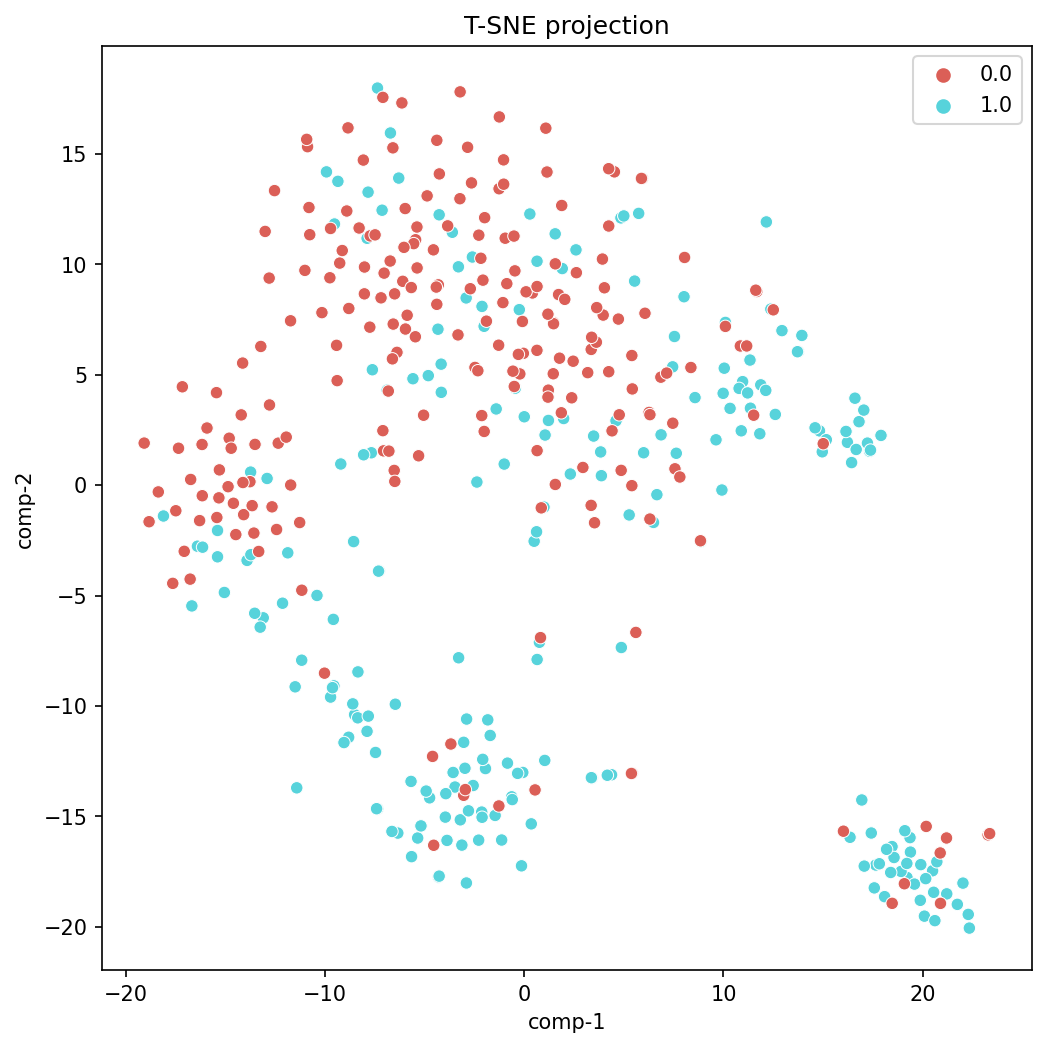

In [65]:
perplexity = 30
learning_rate = 20
n_colors = 2
figsize = (8, 8)

figure(figsize=figsize, dpi=150)

z = TSNE(n_components=2, init='random').fit_transform(X_test_full_ST_embedding) 
#, learning_rate = 20, perplexity=perplexity

df = pd.DataFrame()
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=test_ST_labels, palette=sns.color_palette("hls", n_colors), data=df).set(title="T-SNE projection")

(33, 1024)

In [ ]:
"ERLSGSGLHWPLSRTR S EPLPPSATAPPPPGPM"

In [40]:
pt5_all[16,:]

array([ 0.18102677, -0.05428649,  0.31920186, ..., -0.04467595,
        0.25884712,  0.11172821], dtype=float32)

In [ ]:
seq = "MLKNLAKLDQTEMDKVNVDLAAAGVAFKERYNMPVIAEAVEREQPEHLRSWFRERLIAHRLASVNLSRLPYEPKLK"
pt5_all = get_protT5_features(seq)

In [ ]:
pt5_all[K_pos_1 - 1, ]

In [ ]:
'''
import pandas as pd
import numpy as np
import h5py

device = torch.device('cpu')
model = model.to(device)
model = model.eval()

def extract_embed(path, h5_path):  
    agg_embedding = list()
    seq_df = pd.read_csv(path, sep=",")
    seqs = seq_df["Sequence"].tolist()
    for seq in seqs:
        seq = re.sub(r"[UZOB]", "X", seq)
        seq = " ".join(seq)
        ids = tokenizer.batch_encode_plus(seq, add_special_tokens=True, padding=True)
        input_ids = torch.tensor(ids['input_ids']).to(device)
        attention_mask = torch.tensor(ids['attention_mask']).to(device)
        with torch.no_grad():
            embedding = model(input_ids=input_ids, attention_mask=attention_mask)
        embedding = embedding.last_hidden_state.cpu().numpy()
        seq_len = (attention_mask[0] == 1).sum()
        seq_emd = embedding[0][:seq_len-1]
        agg_embedding.append(seq_emd)

    X = np.array(agg_embedding)
    X = np.squeeze(X, axis=1)
    hf = h5py.File(h5_path, 'w')
    hf.create_dataset('embedding', data=X)
    hf.close()
extract_embed("../data/train/dataframe/positive_sites.csv", "../data/train/dataframe/prot_t5_xl_bfd_features_pos.h5")
'''